In [1]:
from datasets import *
from model import *
from config import *
from visualize import visualize_pointcloud
from train import *

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 10/18/23 08:26:29.964 2836906] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:

def visualize_pointcloud_components(pts):
    namo_colors = [
    '#1f77b4',  # muted blue
    '#005073',  # safety orange
    '#96aab3',  # cooked asparagus green
    '#2e3e45',  # brick red
    '#08455e',  # muted purple
    '#575959',  # chestnut brown
    '#38677a',  # raspberry yogurt pink
    '#187b96',  # middle gray
    '#31393b',  # curry yellow-green
    '#1cd1ed'   # blue-teal
    ]
    all_pts = pts.reshape([-1,3])
    N = pts.shape[0]
    rang = 0.7
    s = 3.0
    fig = plt.figure("visualize",figsize=(s * N//2,s * 2), frameon = True)
    full_fig = plt.figure("full_viz", figsize = (s,s), frameon = False)
    full_rows = 2
    full_cols = N // 2 
    full_ax = full_fig.add_subplot(1,1,1,projection='3d')
    full_ax.set_axis_off()
    full_ax.set_zlim(-rang,rang);full_ax.set_xlim(-rang,rang);full_ax.set_ylim(-rang,rang)
    for i in range(N):
        row = i // full_cols
 
        ax = fig.add_subplot(2, full_cols , 1 + i  , projection='3d')
        ax.set_zlim(-rang,rang);ax.set_xlim(-rang,rang);ax.set_ylim(-rang,rang)
        # make the panes transparent
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis._axinfo['axisline']['linewidth'] = 1
            axis._axinfo['axisline']['color'] = (0, 0, 0)
            #axis._axinfo['grid']['linewidth'] = 0.5
            #axis._axinfo['grid']['linestyle'] = "-"
            axis._axinfo["grid"]['color'] =  (1,1,1,0)
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.set_axis_off()
        #ax.view_init(elev = -80, azim = -90)
        for j in range(N):
            coords = pts[j]
            colors = namo_colors[j]
            alpha = 1.0 if i == j else 0.05
            ax.scatter(coords[:,0],coords[:,1],coords[:,2], c = colors, alpha = alpha)
        coords = pts[i]
        colors = namo_colors[i]
        full_ax.scatter(coords[:,0],coords[:,1],coords[:,2], c = colors)
    fig.savefig("outputs/pc_components.png")
    full_fig.savefig("outputs/pc_full_components.png")

In [3]:
argparser = argparse.ArgumentParser()
# [general config of the training]
argparser.add_argument("--phase",                   default = "0")
argparser.add_argument("--device",                  default = config.device)
argparser.add_argument("--name",                    default = "KFT")
argparser.add_argument("--epoch",                   default = 400 * 3)
argparser.add_argument("--optimizer",               default = "Adam")
argparser.add_argument("--lr",                      default = 2e-4)
argparser.add_argument("--batch_size",              default = 1)
argparser.add_argument("--dataset",                 default = "StructureNet")
argparser.add_argument("--category",                default = ["chair"])
argparser.add_argument("--freeze_perception",       default = False)
argparser.add_argument("--concept_type",            default = False)

# [perception and language grounding training]
argparser.add_argument("--perception",              default = "csqnet")
argparser.add_argument("--training_mode",           default = "joint")
argparser.add_argument("--alpha",                   default = 1.00)
argparser.add_argument("--beta",                    default = 1.0)

# [additional training details]
argparser.add_argument("--warmup",                  default = True)
argparser.add_argument("--warmup_steps",            default = 300)
argparser.add_argument("--decay",                   default = False)
argparser.add_argument("--decay_steps",             default = 20000)
argparser.add_argument("--decay_rate",              default = 0.99)
argparser.add_argument("--shuffle",                 default = True)

# [curriculum training details]
argparser.add_argument("--effective_level",         default = 1)

# [checkpoint location and savings]
argparser.add_argument("--checkpoint_dir",          default = False)
argparser.add_argument("--checkpoint_itrs",         default = 10,       type=int)
argparser.add_argument("--pretrain_perception",     default = False)

args = argparser.parse_args(args = [])

if __name__ == "__main__":
    args.checkpoint_dir = "checkpoints/KFT_StructureNet_0.ckpt"

model = Halearner(config)

/Users/melkor/Documents/GitHub/Hierarchical-Learner/HierarchyLearner/knowledge/structure_chair_concept_vocab.txt


start the demo
StructureGrouding Net with  ['chair']


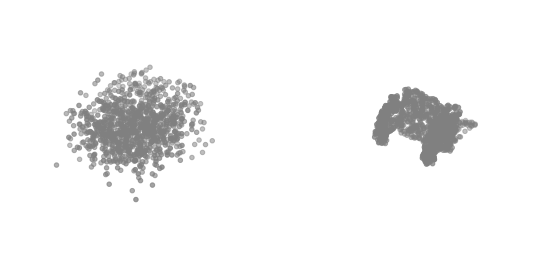

In [4]:

print("start the demo")

B = 1
if args.dataset == "StructureNet":
    dataset = StructureGroundingDataset(config, category=args.category, split = "train")
if args.dataset == "Multistruct":dataset = multistructnet4096("train","airplane", False)
dataloader = DataLoader(dataset, batch_size = B, shuffle = False)

# [Get A Sample Data]
itr = 0
for sample in dataloader:
    sample, gt = sample
    itr += 1
    if itr == 2:
        break

model.perception.split_components = True
outputs = model.perception(sample)

components = outputs["components"]

coords = outputs["recon_pc"].detach()
n = coords.shape[0]
coords_colors = torch.ones([n,3]) * 0.5

in_coords = sample["point_cloud"][0]
n = in_coords.shape[0]
in_colors = torch.ones([n,3]) * 0.5
input_pcs = [(coords,coords_colors),[in_coords, in_colors]]

visualize_pointcloud(input_pcs)

This is the comparison between the reconstruct point cloud and input point cloud.

In [5]:
visualize_pointcloud_components(components[0].detach())

This the primitive segmentation of parts of the point cloud.

In [ ]:
print(outputs["features"].shape)
base_features = outputs["features"]
object_map = nn.Linear(131,100)
base_features = object_map(base_features)
print(base_features.shape)

torch.Size([1, 10, 131])
torch.Size([1, 10, 100])


In [ ]:
scene_struct = model.build_scene(base_features)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [ ]:
for s in reversed(scene_struct["scores"]):print(s[0])
for f in reversed(scene_struct["features"]):print(f[0].shape)
print("Match Matrix:")
for c in reversed(scene_struct["connections"]):print(c[0].shape)

tensor([0.4085], grad_fn=<SelectBackward0>)
tensor([0.4085, 0.2801, 0.2779, 0.2854], grad_fn=<SelectBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
torch.Size([1, 100])
torch.Size([4, 100])
torch.Size([10, 100])
Match Matrix:
torch.Size([1, 4])
torch.Size([4, 10])


Question Ansering Based on Structured Scene.

In [ ]:
def load_scene(scene, k): 
    scores = scene["scores"]; features = scene["features"]; connections = scene["connections"]
    return [score[k] for score in scores], [feature[k] for feature in features], \
        [connection[k] for connection in connections[1:]]

In [ ]:
scores,features,connections = load_scene(scene_struct, 0)

kwargs = {"features":features,
        "end":scores,
        "connections":connections}


qa_programs = [
    "exist(filter(scene(),leg))",
    ]
answers = [
    "yes"
]

language_loss = 0.0
model.executor.effective_level = 1
for i,q in enumerate(qa_programs):
        answer = answers[i]

        q = model.executor.parse(q)

                        
        o = model.executor(q, **kwargs)
        
        print(q,answer)
        print(o["end"].sigmoid().detach().numpy())

        if answer in ["True","False"]:answer = {"True":"yes,","False":"no"}[answer]
        if answer in ["1","2","3","4","5"]:answer = num2word(int(answer))
                        
        if answer in numbers:
            int_num = torch.tensor(numbers.index(answer)).float().to(args.device)
            language_loss += F.mse_loss(int_num ,o["end"])
                            
        if answer in yes_or_no:
            if answer == "yes":
                language_loss -= torch.log(torch.sigmoid(o["end"]))
            else:
                language_loss -= torch.log(1 - torch.sigmoid(o["end"]))

Exist(Filter(Scene(), leg)) yes
[0.01284887 0.01284887 0.01284887 0.01284887 0.01284887 0.01284887
 0.01284887 0.01284887 0.01284887 0.01284887]


In [ ]:
args.epoch = 2000
model.perception.split_components = False
model = train(model, config, args, num_sample = 2)

start the experiment: KFT query:[False]
experiment config: 
epoch: 2000 
batch: 1 samples 
lr: 0.0002

Epoch: 43, Itrs: 84 Loss: 0.012187139131128788 Percept:0.012187139131128788 Language:0.0, Time: 0:00:13.510344

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

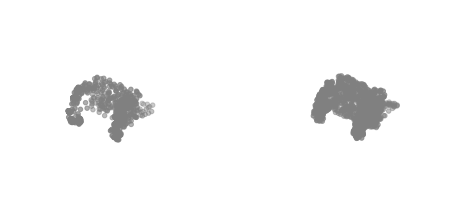

In [ ]:
# Contents After the Training
model.perception.split_components = True
outputs = model.perception(sample)

components = outputs["components"]

coords = outputs["recon_pc"].detach()
n = coords.shape[0]
coords_colors = torch.ones([n,3]) * 0.5

in_coords = sample["point_cloud"][0]
n = in_coords.shape[0]
in_colors = torch.ones([n,3]) * 0.5
input_pcs = [(coords,coords_colors),[in_coords, in_colors]]

visualize_pointcloud(input_pcs)
#visualize_pointcloud_components(components[0].detach())

scene_struct = model.build_scene(base_features)

#for s in reversed(scene_struct["scores"]):print(s[0])
#for f in reversed(scene_struct["features"]):print(f[0].shape)
#print("Match Matrix:")
#for c in reversed(scene_struct["connections"]):print(c[0].shape)

In [ ]:
args.epoch = 3500
args.alpha = 1.0
args.beta = 0.01
model.perception.split_components = False
#print(sample)
model = train(model, config, args, num_sample = 2, phase = "1")

start the experiment: KFT query:[True]
experiment config: 
epoch: 3500 
batch: 1 samples 
lr: 0.0002

StructureGrouding Net with  chair
Epoch: 3500, Itrs: 6999 Loss: 0.009278038516640663 Percept:0.002182834781706333 Language:0.7095203995704651, Time: 1:13:24.45712065318

Experiment KFT : Training Completed.


StructureGrouding Net with  ['chair']
0.88923544
Exist(Filter(Scene(), leg)) yes
0.5007934
Count(Filter(Scene(), chair)) no
tensor([-5.3567,  2.0830, -5.3031,  1.5313], grad_fn=<CatBackward0>)
tensor([-16.1181, -16.1181, -16.1181], grad_fn=<CatBackward0>)
tensor([-16.1181], grad_fn=<CatBackward0>)


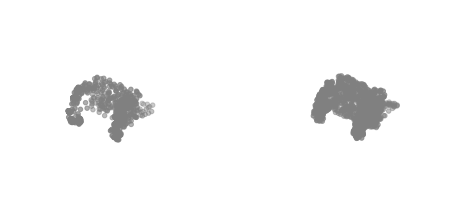

[tensor([[0.3886, 0.3234, 0.2588, 0.3328],
        [0.3018, 0.2752, 0.3664, 0.4103],
        [0.3095, 0.4014, 0.3748, 0.2570]], grad_fn=<SelectBackward0>), tensor([[0.3886, 0.4103, 0.4014]], grad_fn=<SelectBackward0>)]


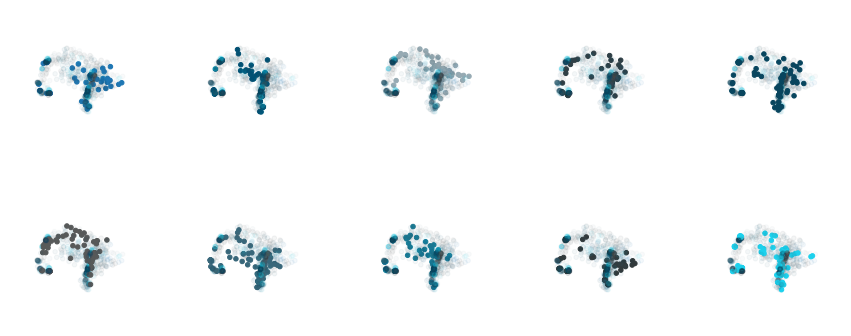

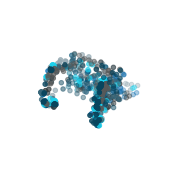

In [ ]:

train_dataset = StructureGroundingDataset(config, category = args.category, split = "train", phase = "1")

train_dataset = torch.utils.data.Subset(train_dataset, list(range(10)))
dataloader = DataLoader(train_dataset, batch_size = int(args.batch_size), shuffle = args.shuffle)

for sample in dataloader:
    sample, gt = sample
    break;
#print(sample)


model.perception.split_components = True
outputs = model.perception(sample)

base_features = outputs["features"]
base_features = model.feature2concept(base_features)

visualize_pointcloud(input_pcs)
#visualize_pointcloud_components(components[0].detach())

scene_struct = model.build_scene(base_features)

scores,features,connections = load_scene(scene_struct, 0)

kwargs = {"features":features,
        "end":scores,
        "connections":connections}


qa_programs = [
    "exist(filter(scene(),leg))",
    "count(filter(scene(),chair))",
    "filter(scene(),leg)",
    ]
answers = [
    "yes","no","na","na"
]

language_loss = 0.0
model.executor.effective_level = 1
for i,q in enumerate(qa_programs):
        answer = answers[i]

        q = model.executor.parse(q)

                        
        o = model.executor(q, **kwargs)
        
        
        if isinstance(o["end"],list):
            for item in o["end"]:print(item)
        else:
            print(o["end"].sigmoid().detach().numpy())
            print(q,answer)
plt.show()
visualize_pointcloud_components(components[0].detach())
print(connections)